# Count Random Forest

In [17]:
FILE_NAME = 'count_random_forest'
GRAPH_TITLE = 'Count + Random Forest'

In [18]:
import polars as pl
from utils.load_data import get_data

In [19]:
X_train, X_test, y_train, y_test = get_data("s")

## Fit Model

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [21]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", RandomForestClassifier(n_jobs=-2, n_estimators=100))
    ]
)

In [22]:
classifier = pipeline.fit(X_train, y_train)

In [23]:
classifier.classes_

array(['false', 'true'], dtype=object)

## Evaluation

In [24]:
from utils.plot import plot_eval
import sklearn.metrics as metrics

In [25]:
y_pred = classifier.predict(X_test)
clf_report = metrics.classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

       false       0.94      0.95      0.95     15956
        true       0.95      0.94      0.94     16044

    accuracy                           0.95     32000
   macro avg       0.95      0.95      0.95     32000
weighted avg       0.95      0.95      0.95     32000



In [26]:
evaluation_reuslt = {
    "auc": metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]),
    "accuracy": metrics.accuracy_score(y_test, y_pred),
    "precision": metrics.precision_score(y_test, y_pred, pos_label='true'),  # type: ignore
    "recall": metrics.recall_score(y_test, y_pred, pos_label='true'),  # type: ignore
    "f1": metrics.f1_score(y_test, y_pred, pos_label='true'), # type: ignore
}
evaluation_reuslt

{'auc': 0.9873616270785548,
 'accuracy': 0.94503125,
 'precision': 0.949185585812213,
 'recall': 0.9407255048616305,
 'f1': 0.9449366097980904}

/home/kooler/dev/sw/sns-fake-content/model/utils/plot.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


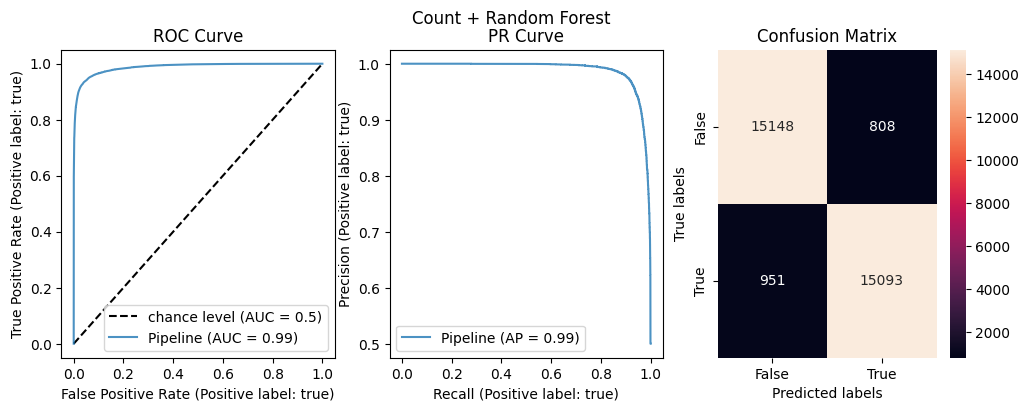

In [27]:
plt = plot_eval(X_test, y_test, y_pred, classifier, GRAPH_TITLE)
plt.savefig(f"output/{FILE_NAME}.png")

## LIAR Test

In [28]:
from utils.load_data import load_liar

X_liar, y_liar = load_liar()

In [29]:
from sklearn.metrics import classification_report

y_liar_pred = classifier.predict(X_liar)

clf_report_liar = classification_report(y_liar, y_liar_pred)
print(clf_report_liar)

              precision    recall  f1-score   support

       false       0.65      0.32      0.43      8284
        true       0.35      0.69      0.47      4507

    accuracy                           0.45     12791
   macro avg       0.50      0.50      0.45     12791
weighted avg       0.55      0.45      0.44     12791



/home/kooler/dev/sw/sns-fake-content/model/utils/plot.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


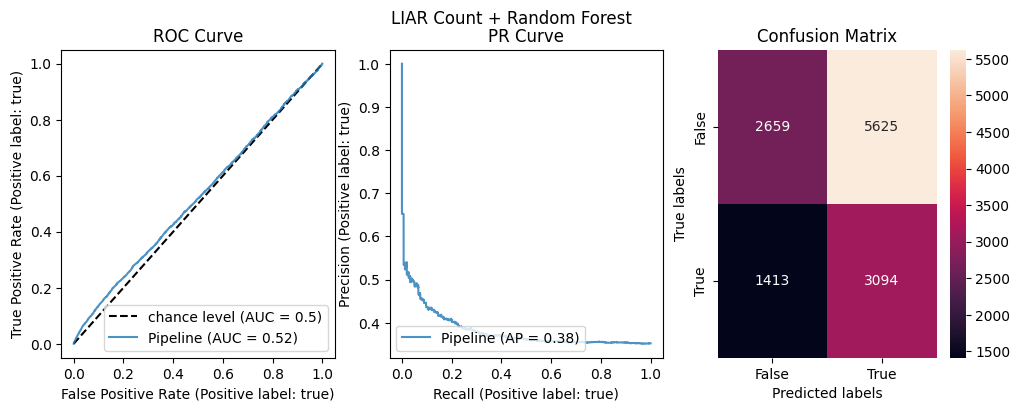

In [30]:
plt = plot_eval(X_liar, y_liar, y_liar_pred, classifier, f"LIAR {GRAPH_TITLE}")
plt.savefig(f"output/{FILE_NAME}_liar.png")

In [31]:
import json 

with open(f'./output/result_eval_{FILE_NAME}.txt', 'w') as writer:
    writer.write("Evaluation Result\n")
    writer.write(clf_report)
    writer.write('\n')
    writer.write("LIAR Evaluation Result\n")
    writer.write(clf_report_liar)
    writer.write('\n')
    writer.write("Accurate Result\n")
    writer.write(json.dumps(evaluation_reuslt, indent=4))

## Export model

In [32]:
from joblib import dump, load
dump(classifier, f'output/{FILE_NAME}.joblib') 

['output/count_random_forest.joblib']

In [33]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

initial_type = [("text", StringTensorType([None,]))]
onx = convert_sklearn(classifier, initial_types=initial_type)
with open(f"output/{FILE_NAME}.onnx", "wb") as f:
    f.write(onx.SerializeToString())


In [34]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy

sess = rt.InferenceSession(f"output/{FILE_NAME}.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [36]:
pred_onx = sess.run(None, {input_name: X_test})
pred_onx

[array(['false', 'false', 'false', ..., 'true', 'false', 'false'],
       dtype=object),
 [{'false': 0.949999988079071, 'true': 0.04999999701976776},
  {'false': 0.8170000314712524, 'true': 0.18299999833106995},
  {'false': 1.0, 'true': 0.0},
  {'false': 0.019999802112579346, 'true': 0.9800001978874207},
  {'false': 0.1700001358985901, 'true': 0.8299998641014099},
  {'false': 0.06999999284744263, 'true': 0.9300000071525574},
  {'false': 0.009999871253967285, 'true': 0.9900001287460327},
  {'false': 0.11000001430511475, 'true': 0.8899999856948853},
  {'false': 0.6399999856948853, 'true': 0.35999998450279236},
  {'false': 0.3400000333786011, 'true': 0.6599999666213989},
  {'false': 0.7899999618530273, 'true': 0.21000002324581146},
  {'false': 0.9462162256240845, 'true': 0.05378375202417374},
  {'false': 1.0, 'true': 0.0},
  {'false': 0.7396667003631592, 'true': 0.2603332996368408},
  {'false': 1.0, 'true': 0.0},
  {'false': 0.7200000286102295, 'true': 0.2800000011920929},
  {'false': 0.1